# Dispersion Analysis: Fornberg vs. DRP Stencils

In [1]:
import numpy as np
import scipy as sp
import sympy as sym
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from functools import partial
from matplotlib import patheffects
from numpy import linalg as la
import segyio
import sys
from scipy.interpolate import RegularGridInterpolator
from scipy.interpolate import RectBivariateSpline

In [2]:
from devito import Grid, Function, TimeFunction, SparseTimeFunction, Eq, Operator, solve

In [3]:
normtype  = np.inf

## 1. Problem Setup

In [4]:
def ricker(t, f):
    
    val1 = 1-2*((np.pi*f)*(t-1/f))**2
    val2 = -((np.pi*f)**2*(t-1/f)**2)
    val3 = val1*np.exp(val2)

    return val3

In [5]:
f0       = 0.02
npointsx = 401
npointsy = 401
extentx  = 1000
extenty  = 1000
hx       = extentx/(npointsx-1)
hy       = extentx/(npointsy-1)
t1       = 300
vvel     = 1.5*np.ones((npointsx,npointsy))
vmax     = np.amax(vvel)

In [6]:
hx,hy

(2.5, 2.5)

In [7]:
def critical_dt(weights,h,vmax):
    
    a = h*np.sqrt(2/np.sum([np.abs(a) for a in weights]))/vmax
    
    return float(a)

In [8]:
def critical_h(weights,dt,vmax):

    a = float(np.sqrt(2/np.sum([np.abs(a) for a in weights]))/(vmax*dt))
    b = 1/a
    
    return b

In [9]:
def acoustic(weightsx,weightsy,hx,hy,dt,vmodel,f,extentx,extenty,t1,factor=1):

    origin = (0., 0.)
    grid_extent = (extentx, extenty)
    snx = int(np.ceil((grid_extent[0] - origin[0])/hx))
    sny = int(np.ceil((grid_extent[1] - origin[1])/hy))
    shape = (snx, sny)
    
    t0 = 0
    tn = int(np.ceil((t1 - t0)/dt))

    vmax = np.amax(vmodel)
    
    r = vmax*dt/min(hx,hy)

    weightsx = np.concatenate([weightsx[::-1], weightsx[1:]])
    weightsy = np.concatenate([weightsy[::-1], weightsy[1:]])
    space_order = len(weightsx) - 1

    sx = grid_extent[0]/2 - origin[0]
    sy = grid_extent[1]/2 - origin[1]

    grid = Grid(shape=shape, extent=grid_extent)
    x, y = grid.dimensions

    velocity = Function(name="velocity", grid=grid, space_order=space_order)
    
    if(factor!=1):

        xoriginal        = np.linspace(0, extentx, vmodel.shape[0])
        yoriginal        = np.linspace(0, extenty, vmodel.shape[1])
        interp_spline    = RectBivariateSpline(xoriginal, yoriginal, vmodel)
        xx               = np.linspace(0, extentx, snx)
        yy               = np.linspace(0, extenty, sny)        
        vvelinterp       = interp_spline(xx, yy)
        velocity.data[:] = vvelinterp[:]

    else:

        velocity.data[:] = vmodel[:]

    
    t = np.linspace(t0, t1, tn)
    source = SparseTimeFunction(
        name="ricker",
        npoint=1,
        coordinates=[(sx, sy)],
        nt=tn,
        grid=grid,
        time_order=2,
        space_order=space_order
    )
    source.data[:, 0] = ricker(t,f=f)

    nrecv = vmodel.shape[0]
    rx = np.linspace(origin[0], grid_extent[0], nrecv)
    ry = (grid_extent[1]/2 - origin[1])*np.ones(nrecv)
    
    receiver = SparseTimeFunction(
        name="recv",
        npoint=nrecv,
        coordinates=np.array([rx, ry]).T,
        nt=tn,
        grid=grid
    )

    u = TimeFunction(name="u", grid=grid, time_order=2, space_order=space_order)

    pde = (1/velocity**2)*u.dt2 - u.dx2(weights=weightsx) - u.dy2(weights=weightsy)

    stencil = Eq(u.forward, solve(pde, u.forward))
    
    src_term = source.inject(field=u.forward, expr=source*factor*factor*velocity*velocity*dt*dt)
    recv_term = receiver.interpolate(expr=u.forward)
    op = Operator([stencil] + src_term + recv_term, subs=grid.spacing_map)
    op(time=tn - 1, dt=dt)
    
    return u.data[-1], receiver.data, r

In [10]:
def critical_cfl(weights,h,dt,vmax):

    limit  = np.sqrt(2/np.sum([np.abs(a) for a in weights]))
    rvalue = (dt*vmax)/h

    print('Limit Value: %f'%limit)
    print('RVALUE: %f'%rvalue)
    
    if(limit>rvalue): 
        
        print('Stable Choice of weights,h,dt and vel!')
        print('')

    else:

        print('WARNING!"')
        print('Unstable Choice of weights, h,dt and vel!')
        print('')
        
    return

In [11]:
M = 20
x = [(1-(-1)**n*(2*n+1))//4 for n in range(2*M + 1)]
N = 2
weightsteste  = sym.finite_diff_weights(N, x, 0)
fornbergteste = np.array(weightsteste[-1][-1][::2], dtype=np.float64)

In [12]:
dtinitial = critical_dt(fornbergteste,hx,vmax)

In [13]:
dtinitial

0.983246447059379

In [14]:
critical_cfl(fornbergteste,hx,dtinitial,vmax)

Limit Value: 0.589948
RVALUE: 0.589948
WARNING!"
Unstable Choice of weights, h,dt and vel!



In [15]:
uteste,datateste,rteste = acoustic(fornbergteste,fornbergteste,hx,hy,dtinitial,vvel,f0,extentx,extenty,t1)

Operator `Kernel` ran in 0.14 s


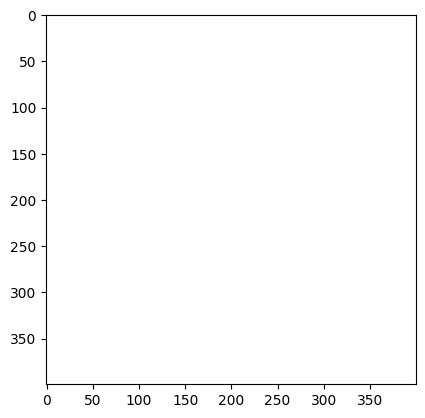

In [16]:
plt.imshow(np.transpose(uteste))

In [17]:
uteste,datateste,rteste = acoustic(fornbergteste,fornbergteste,hx,hy,0.01*dtinitial,vvel,f0,extentx,extenty,t1)

Operator `Kernel` ran in 12.95 s


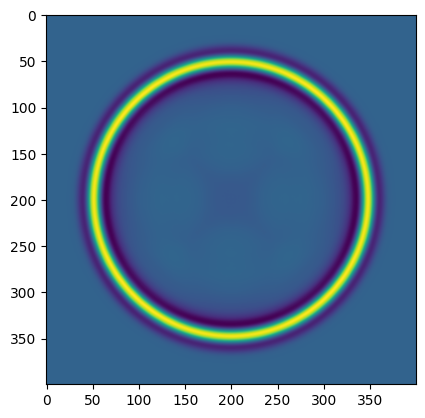

In [18]:
plt.imshow(np.transpose(uteste))

In [19]:
vdt    = np.linspace(0.01*dtinitial,0.94*dtinitial,20)
nvdt   = vdt.shape[0]
morder = 4

## 2. Fornberg

In [20]:
lnormuf   = []

for k1 in range(0,nvdt):
    
    try:
    
        M = morder
        x = [(1-(-1)**n*(2*n+1))//4 for n in range(2*M + 1)]
        N = 2
        weights     = sym.finite_diff_weights(N, x, 0)
        fornberg    = np.array(weights[-1][-1][::2], dtype=np.float64)
        dtloc       = vdt[k1] 
        uf,dataf,rf = acoustic(fornberg,fornberg,hx,hy,dtloc,vvel,f0,extentx,extenty,t1)
    
        lnormu = la.norm(uf,normtype)
        lnormuf.append(lnormu)

    except:
        
            lnormuf.append(lnormu)

Operator `Kernel` ran in 2.67 s
Operator `Kernel` ran in 0.49 s
Operator `Kernel` ran in 0.27 s
Operator `Kernel` ran in 0.18 s
Operator `Kernel` ran in 0.14 s
Operator `Kernel` ran in 0.11 s
Operator `Kernel` ran in 0.10 s
Operator `Kernel` ran in 0.08 s
Operator `Kernel` ran in 0.07 s
Operator `Kernel` ran in 0.07 s
Operator `Kernel` ran in 0.06 s
Operator `Kernel` ran in 0.05 s
Operator `Kernel` ran in 0.05 s
Operator `Kernel` ran in 0.05 s
Operator `Kernel` ran in 0.04 s
Operator `Kernel` ran in 0.04 s
Operator `Kernel` ran in 0.04 s
Operator `Kernel` ran in 0.04 s
Operator `Kernel` ran in 0.04 s
Operator `Kernel` ran in 0.03 s


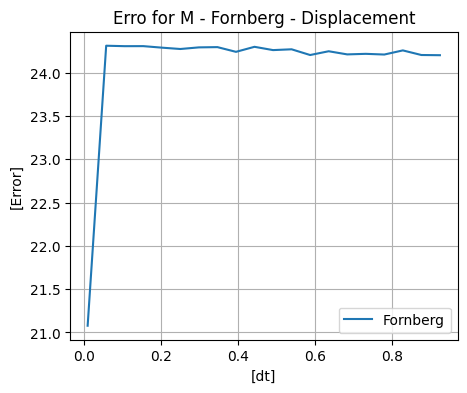

In [21]:
plt.figure(figsize = (5,4))
plt.plot(vdt,lnormuf,label='Fornberg')
plt.grid()
plt.legend()
plt.title('Erro for M - Fornberg - Displacement')
plt.xlabel('[dt]')
plt.ylabel('[Error]')
plt.show()

## 3. DPRS - Method 1

In [22]:
def objective(a):
    x = np.linspace(0, np.pi/2, 201)
    m = np.arange(1, len(a) + 1)
    y = x**2 + a[0] + 2*np.sum([a_ * np.cos(m_*x) for a_, m_ in zip(a[1:], m)], axis=0)
    return sp.integrate.trapezoid(y**2, x=x)

In [23]:
lnormudrp1   = []

for k1 in range(0,nvdt):

    try:
    
        M = morder
        x = [(1-(-1)**n*(2*n+1))//4 for n in range(2*M + 1)]
        N = 2
        weights     = sym.finite_diff_weights(N, x, 0)
        fornberg    = np.array(weights[-1][-1][::2], dtype=np.float64)
        
        initial_guess = fornberg
        
        constraints = [{
            'type': 'eq',
            'fun': lambda x: x[0] + 2*np.sum(x[1:])
        }]
        constraints += [{
            'type': 'eq',
            'fun': lambda x: np.sum([xi*m**2 for m, xi in enumerate(x)]) - 1
        }]
        constraints += [{
            'type': 'eq',
            'fun': lambda x: np.sum([xi*m**(2*jj) for m, xi in enumerate(x)])
        } for jj in range(2, (len(initial_guess) + 1)//2)]
        
        opt1 = sp.optimize.minimize(objective, initial_guess, method='SLSQP', constraints=constraints, options=dict(ftol=1e-15, maxiter=500))
        drp_stencil1 = opt1.x
        dtloc       = vdt[k1] 
        uf,dataf,rf = acoustic(drp_stencil1,drp_stencil1,hx,hy,dtloc,vvel,f0,extentx,extenty,t1)
    
        lnormu = la.norm(uf,normtype)
        lnormudrp1.append(lnormu)

    except:
    
        lnormudrp1.append(np.nan)

Operator `Kernel` ran in 2.72 s
Operator `Kernel` ran in 0.49 s
Operator `Kernel` ran in 0.25 s
Operator `Kernel` ran in 0.18 s
Operator `Kernel` ran in 0.14 s
Operator `Kernel` ran in 0.11 s
Operator `Kernel` ran in 0.09 s
Operator `Kernel` ran in 0.08 s
Operator `Kernel` ran in 0.07 s
Operator `Kernel` ran in 0.07 s
Operator `Kernel` ran in 0.06 s
Operator `Kernel` ran in 0.05 s
Operator `Kernel` ran in 0.05 s
Operator `Kernel` ran in 0.05 s
Operator `Kernel` ran in 0.04 s
Operator `Kernel` ran in 0.04 s
Operator `Kernel` ran in 0.04 s
Operator `Kernel` ran in 0.04 s
Operator `Kernel` ran in 0.04 s
Operator `Kernel` ran in 0.03 s


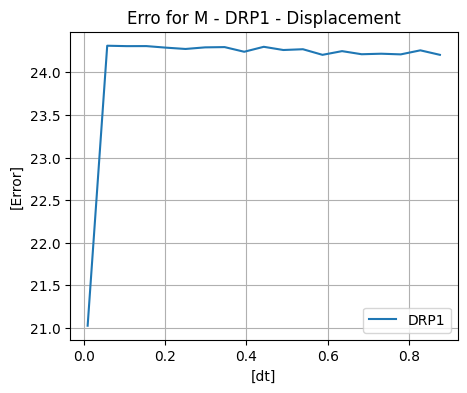

In [24]:
plt.figure(figsize = (5,4))
plt.plot(vdt,lnormudrp1,label='DRP1')
plt.grid()
plt.legend()
plt.title('Erro for M - DRP1 - Displacement')
plt.xlabel('[dt]')
plt.ylabel('[Error]')
plt.show()

## 4.DRPS - Method 2

In [25]:
def dispersion_difference(weights,h,dt,v,k,alpha):
    if k == 0:
        diff = 0
    else:
        m = len(weights)
        cosines = np.array([
            np.cos(m*k*h*np.cos(alpha)) + np.cos(m*k*h*np.sin(alpha)) - 2
            for m in range(1, m)
        ])
        total = np.sum(np.array(weights)[1:]*cosines)
        theta = 1 + (v**2)*(dt**2)*total/(h**2)
        valloc = np.acos(theta)

        if(np.isnan(valloc)==True):

            sys.exit('jasjajaja')
        else:
        
            diff = np.abs(np.acos(theta)/(k*dt) - v)
        
        #diff = np.abs(np.acos(theta)/(k*dt) - v)
    return diff

In [26]:
def objective2(a, h, dt, fmax=100, vmin=np.amin(vvel), vmax=np.amax(vvel), alphamin=0, alphamax=np.pi/4, res=31):
    diff_wrapper = partial(dispersion_difference, weights=a, h=h, dt=dt)

    k_integral = np.zeros(res)
    v_space = np.linspace(vmin, vmax, res)
    alpha_space = np.linspace(alphamin, alphamax, res)
    for ii, v in enumerate(v_space):
        alpha_integral = np.zeros(res)
        k_space = np.linspace(0, 2*np.pi*fmax/v, res)
        for jj, k in enumerate(k_space):
            alpha_data = np.array([
                diff_wrapper(alpha=alpha, k=k, v=v) for alpha in alpha_space
            ])
            alpha_integral[jj] = np.trapezoid(alpha_data, alpha_space)
        k_integral[ii] = np.trapezoid(alpha_integral, k_space)
    v_integral = np.trapezoid(k_integral, v_space)

    return v_integral

In [27]:
lnormudrp2   = []

for k1 in range(0,nvdt):

    try:
    
        M = morder
        x = [(1-(-1)**n*(2*n+1))//4 for n in range(2*M + 1)]
        N = 2
        weights     = sym.finite_diff_weights(N, x, 0)
        fornberg    = np.array(weights[-1][-1][::2], dtype=np.float64)
        
        initial_guess = fornberg
        dtloc         = vdt[k1] 
        objective2_wrapper = partial(objective2, h=hx, dt=dtloc)
        opt2 = sp.optimize.minimize(objective2_wrapper, initial_guess, constraints=constraints, method='SLSQP')
        drp_stencil2 = opt2.x
        uf,dataf,rf = acoustic(drp_stencil2,drp_stencil2,hx,hy,dtloc,vvel,f0,extentx,extenty,t1)
    
        lnormu = la.norm(uf,normtype)   
        lnormudrp2.append(lnormu)
    
    except:
    
        lnormudrp2.append(np.nan)

Operator `Kernel` ran in 2.84 s
Operator `Kernel` ran in 0.51 s
Operator `Kernel` ran in 0.27 s
Operator `Kernel` ran in 0.19 s
Operator `Kernel` ran in 0.14 s
Operator `Kernel` ran in 0.12 s
Operator `Kernel` ran in 0.10 s
Operator `Kernel` ran in 0.08 s
Operator `Kernel` ran in 0.08 s
Operator `Kernel` ran in 0.07 s
Operator `Kernel` ran in 0.06 s
Operator `Kernel` ran in 0.05 s
Operator `Kernel` ran in 0.05 s
Operator `Kernel` ran in 0.05 s
Operator `Kernel` ran in 0.04 s
Operator `Kernel` ran in 0.04 s
Operator `Kernel` ran in 0.04 s
Operator `Kernel` ran in 0.04 s
Operator `Kernel` ran in 0.04 s
Operator `Kernel` ran in 0.03 s


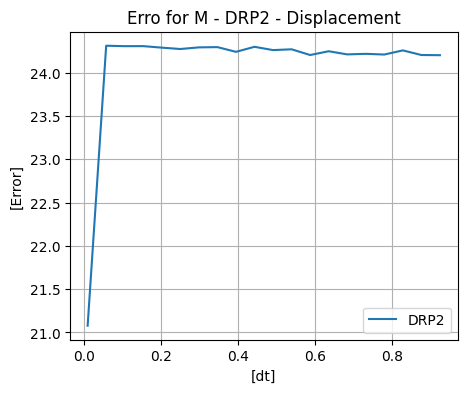

In [28]:
plt.figure(figsize = (5,4))
plt.plot(vdt,lnormudrp2,label='DRP2')
plt.grid()
plt.legend()
plt.title('Erro for M - DRP2 - Displacement')
plt.xlabel('[dt]')
plt.ylabel('[Error]')
plt.show()

## 5. Comparison

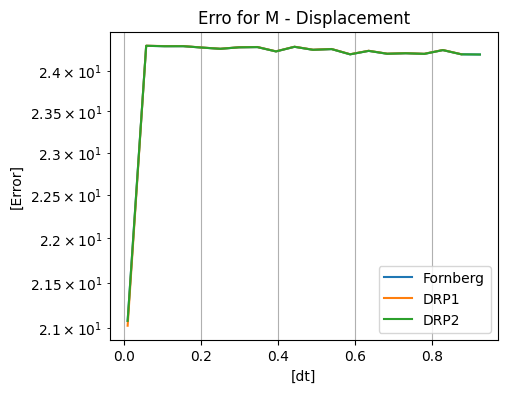

In [32]:
plt.figure(figsize = (5,4))
plt.plot(vdt,lnormuf,label='Fornberg')
plt.plot(vdt,lnormudrp1,label='DRP1')
plt.plot(vdt,lnormudrp2,label='DRP2')
plt.grid()
plt.legend()
plt.title('Erro for M - Displacement')
plt.xlabel('[dt]')
plt.ylabel('[Error]')
plt.yscale('log')
plt.show()